In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from math import sqrt
from catboost import CatBoostRegressor

D:\AnacondaNavigator\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df = pd.read_csv(r'C:/Users/Venom/Desktop/694560_1215964_bundle_archive/preprocessed_data.csv')

In [4]:
df.shape

(2758800, 12)

In [5]:
df.columns

Index(['Region', 'Country', 'City', 'Month', 'Day', 'Year', 'AvgTemperature',
       'Latitude', 'Longitude', 'dist_from_north', 'dist_from_south', 'Date'],
      dtype='object')

In [6]:
df.Date.max(),df.Date.min()

('2019-12-31', '1995-01-01')

In [7]:
df.shape

(2758800, 12)

In [8]:
df.dtypes

Region              object
Country             object
City                object
Month                int64
Day                  int64
Year                 int64
AvgTemperature     float64
Latitude           float64
Longitude          float64
dist_from_north    float64
dist_from_south    float64
Date                object
dtype: object

In [9]:
#yyyy-mm-dd

In [10]:
df['Date'] = pd.to_datetime(df['Date'])

In [11]:
df.Date.quantile(0),df.Date.quantile(1)

(Timestamp('1995-01-01 00:00:00'), Timestamp('2019-12-31 00:00:00'))

In [12]:
def train_test_split(data,column,train_start_date, train_end_date,test_start_date,test_end_date):
    train_start_date = pd.to_datetime(train_start_date)
    train_end_date =  pd.to_datetime(train_end_date)
    test_start_date =  pd.to_datetime(test_start_date)
    test_end_date = pd.to_datetime(test_end_date)
    data[column] = pd.to_datetime(data[column])
    train = data.loc[(data[column]>=train_start_date)&(data[column]<=train_end_date)]
    test = data.loc[(data[column]>=test_start_date)&(data[column]<=test_end_date)]
    train.reset_index(drop =True,inplace = True)
    test.reset_index(drop =True,inplace = True)
    return train,test

In [161]:
df['prev_day'] = df.groupby('City').AvgTemperature.shift(1)
df['prev_2day'] = df.groupby('City').AvgTemperature.shift(2)
df['prev_3day'] = df.groupby('City').AvgTemperature.shift(3)
df['prev_year'] = df.groupby('City').AvgTemperature.shift(365)
df['prev_2year'] = df.groupby('City').AvgTemperature.shift(365*2)
df['prev_3year'] = df.groupby('City').AvgTemperature.shift(365*3)

In [162]:
x_train,x_test = train_test_split(df[df.Region!='North America'].copy(),'Date','1995-01-01','2018-09-02','2018-12-31','2019-12-31')

In [163]:
x_train.shape,x_test.shape

((1187917, 18), (46940, 18))

In [164]:
cat = [i for i in x_train.columns if x_train[i].dtypes=='object']

In [165]:
cat

['Region', 'Country', 'City']

In [166]:
region_temp_mapper = x_train.groupby('Region').AvgTemperature.mean().to_dict()
country_temp_mapper =  x_train.groupby('Country').AvgTemperature.mean().to_dict()
city_temp_mapper =  x_train.groupby('City').AvgTemperature.mean().to_dict()

In [167]:
x_train['Region_enc'] = x_train['Region'].map(region_temp_mapper)
x_test['Region_enc'] = x_test['Region'].map(region_temp_mapper)

x_train['Country_enc'] = x_train['Country'].map(country_temp_mapper)
x_test['Country_enc'] = x_test['Country'].map(country_temp_mapper)

x_train['City_enc'] = x_train['City'].map(city_temp_mapper)
x_test['City_enc'] = x_test['City'].map(city_temp_mapper)

In [168]:
x_train['combined'] = x_train.Country.astype(str)+"_"+x_train.Month.astype(str)
country_month_details = x_train.groupby(['combined']).AvgTemperature.mean().to_dict()
x_train['country_month_mean'] = x_train.combined.map(country_month_details)

x_test['combined'] = x_test.Country.astype(str)+"_"+x_test.Month.astype(str)
x_test['country_month_mean'] = x_test.combined.map(country_month_details)


In [169]:
x_train['combined'] = x_train.City.astype(str)+"_"+x_train.Month.astype(str)
city_month_details = x_train.groupby(['combined']).AvgTemperature.mean().to_dict()
x_train['city_month_mean'] = x_train.combined.map(city_month_details)

x_test['combined'] = x_test.City.astype(str)+"_"+x_test.Month.astype(str)
x_test['city_month_mean'] = x_test.combined.map(city_month_details)


In [170]:
x_train.drop('combined',inplace=True,axis = 1)
x_test.drop('combined',inplace=True,axis = 1)

In [171]:
y_train = x_train.AvgTemperature
y_test = x_test.AvgTemperature

In [172]:
x_train.columns

Index(['Region', 'Country', 'City', 'Month', 'Day', 'Year', 'AvgTemperature',
       'Latitude', 'Longitude', 'dist_from_north', 'dist_from_south', 'Date',
       'prev_day', 'prev_year', 'prev_2year', 'prev_3year', 'prev_2day',
       'prev_3day', 'Region_enc', 'Country_enc', 'City_enc',
       'country_month_mean', 'city_month_mean'],
      dtype='object')

In [192]:
selected = ['Month', 'Longitude', 'dist_from_north',
       'prev_day', 'prev_year','prev_2year','prev_3year' ,'prev_2day',
       'prev_3day','Region_enc', 'City_enc','city_month_mean']
len(selected)

12

In [193]:
x_test[selected].nunique()

Month                12
Longitude           132
dist_from_north     132
prev_day           1067
prev_year          1108
prev_2year         1081
prev_3year         1122
prev_2day          1065
prev_3day          1065
Region_enc            6
City_enc            132
city_month_mean    1573
dtype: int64

In [194]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((1187917, 23), (46940, 23), (1187917,), (46940,))

In [195]:
x_train.columns

Index(['Region', 'Country', 'City', 'Month', 'Day', 'Year', 'AvgTemperature',
       'Latitude', 'Longitude', 'dist_from_north', 'dist_from_south', 'Date',
       'prev_day', 'prev_year', 'prev_2year', 'prev_3year', 'prev_2day',
       'prev_3day', 'Region_enc', 'Country_enc', 'City_enc',
       'country_month_mean', 'city_month_mean'],
      dtype='object')

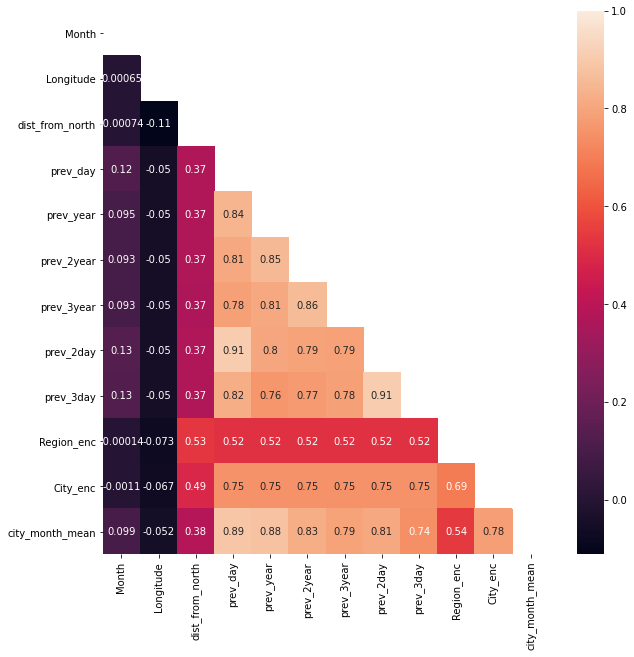

In [196]:
plt.figure(figsize=(10,10))
matrix = np.triu(x_train[selected].corr())
sns.heatmap(x_train[selected].corr(), annot=True, mask=matrix)

In [202]:
model = lgb.LGBMRegressor(n_estimators=700, max_depth=5,learning_rate=0.01)
model.fit(x_train[selected].fillna(0,axis = 1),y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=5,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=700, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

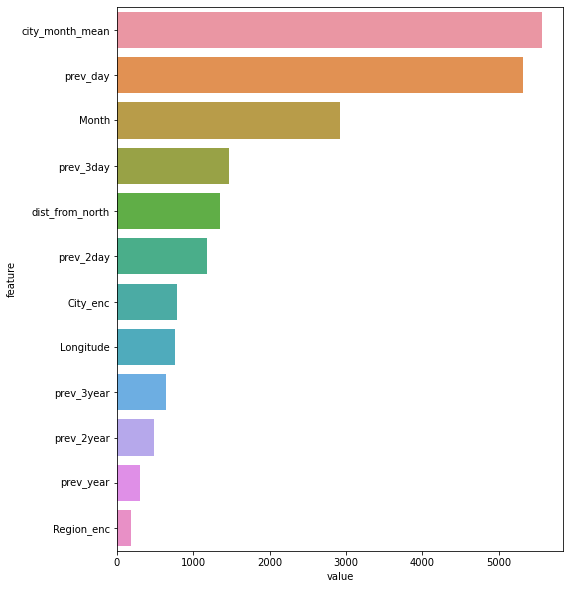

In [203]:
feat_importance = pd.DataFrame()
feat_importance["feature"] = selected
feat_importance["value"] = model.feature_importances_
feat_importance.sort_values(by='value', ascending=False, inplace=True)

plt.figure(figsize=(8,10))
ax = sns.barplot(y="feature", x="value", data=feat_importance)

In [204]:
pred = model.predict(x_test[selected])

In [205]:
rmse = sqrt(mean_squared_error(y_test, pred))
print("RMSE : ",rmse)

RMSE :  4.050339946128423


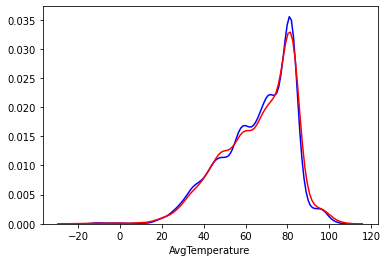

In [206]:
sns.distplot(pred, hist=False,color='b')
sns.distplot(y_test, hist=False,color='r')

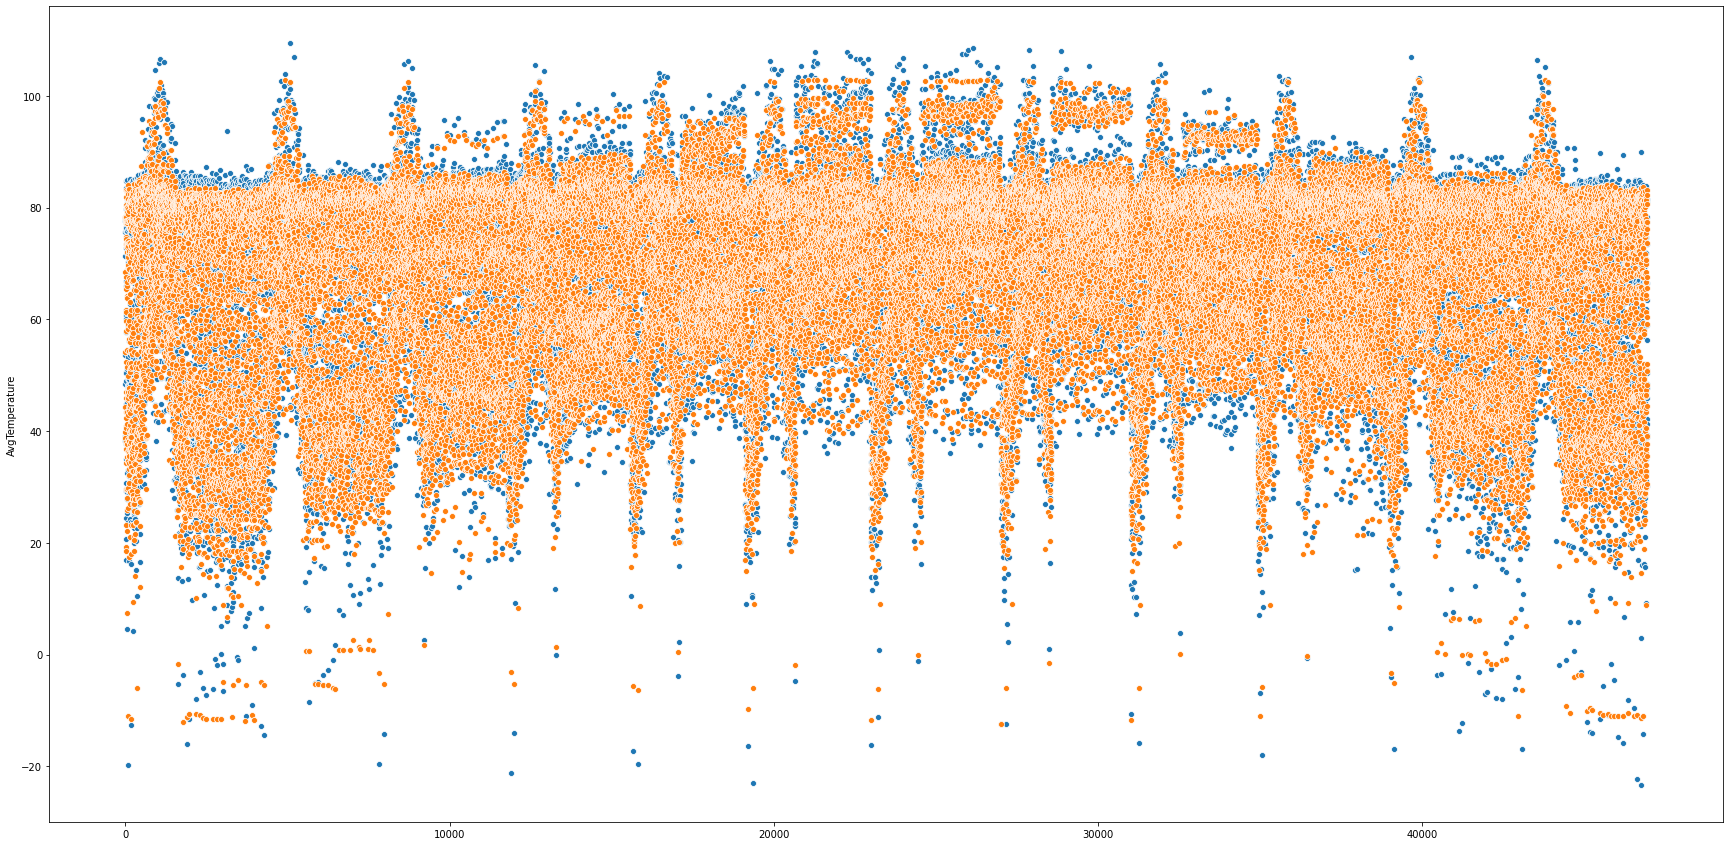

In [207]:
plt.figure(figsize=(30,15))
sns.scatterplot(np.arange(y_test.shape[0]),y_test)
sns.scatterplot(np.arange(y_test.shape[0]),pred)

In [208]:
result = pd.DataFrame()
result = x_test
result['actual'] = y_test
result['predicted'] = pred

In [209]:
result['error'] = np.abs(result.actual-result.predicted)

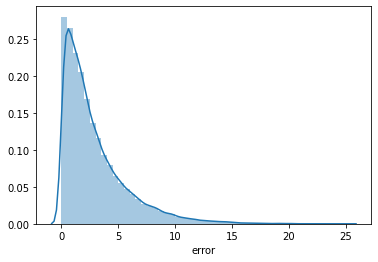

In [210]:
sns.distplot(result.error)

In [211]:
print("SPOT ON % : ",result[result.predicted.astype(int)==result.actual.astype(int)].shape[0]/result.shape[0]*100)
print("+-3 % : ",result[result.error<=3].shape[0]/result.shape[0]*100)
print("+-5 % : ",result[result.error<=5].shape[0]/result.shape[0]*100)
print("+-7 % : ",result[result.error<=7].shape[0]/result.shape[0]*100)

SPOT ON % :  13.757988922028122
+-3 % :  64.45462292288028
+-5 % :  82.14103110353643
+-7 % :  91.05453770771197


In [213]:
result.groupby('Region').error.quantile(0.9)

Region
Africa                               4.139338
Asia                                 7.097271
Australia/South Pacific              7.643294
Europe                               8.362932
Middle East                          6.121249
South/Central America & Carribean    3.879897
Name: error, dtype: float64